In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from sklearn import tree
from seaborn import heatmap
from seaborn import boxplot
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split

# Loading Data
O dataset foi obtido no seguinte [link](http://archive.ics.uci.edu/ml/datasets/Iris).
O dataset Iris é composto por 150 instâncias, possuindo 5 atributos sendo eles: sepal_lenght, sepal_width, petal_lenght, petal_width e class_labels. Aos quais os 4 primeiros serão utilizados para efetuar as predições e o último é o atributo alvo, composto por três classes, sendo elas: Iris-setosa, Iris-versicolor e Iris-virginica.

In [3]:
iris_data = pd.read_csv('/content/gdrive/My Drive/Huawei/iris_dataset.csv', names=['sepal_lenght','sepal_width','petal_lenght','petal_width','class_labels'])

# Random seed
Foi gerada uma variável para armazenar o valor da random seed e dessa forma ser utilizada para atribuir o valor do random_state em cada particionamento de dataset. Dessa forma evita-se que a alteração tenha que ser efetuada de um em um. Essa variável obteve destaque após ser avaliado que sua alteração gera resultados diferentes em cada modelo.

In [ ]:
random_seed = 1

# Splitting Data
Gerando os datasets para treinamento e validação.

*   test_size = 30: Foi definido que o dataset de validação teria 30% dos dados originais para que possua 45 instâncias dessa forma, aliado ao stratify, possa possuir 15 instâncias de cada classe.  
*   stratify = y: Utilizado para fazer o balanceamento das instâncias ao fazer o split, deve se capturar a mesma quantidade de instâncias de cada atributo alvo.
*   random_state=random_seed: Chave aleatória definida arbitrariamente, dessa forma ao re-executar o código, sempre será gerada a mesma partição.

Após a partição, o dataset de treino possui 105 instâncias enquanto o de teste possui 45.


In [4]:
x = iris_data[['sepal_lenght','sepal_width','petal_lenght','petal_width']]
y = iris_data[['class_labels']]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30, stratify=y, random_state=random_seed)

# Plotting Dataset
Para a melhor compreensão dos dados que estão sendo utilizados, foi plotado o dataset original antes do particionamento. Desde já é possível verificar que os atributos petal_length e petal_width estão melhor divididos, como se formassem clusters, isso deve ser melhor explorado no decorrer do projeto.

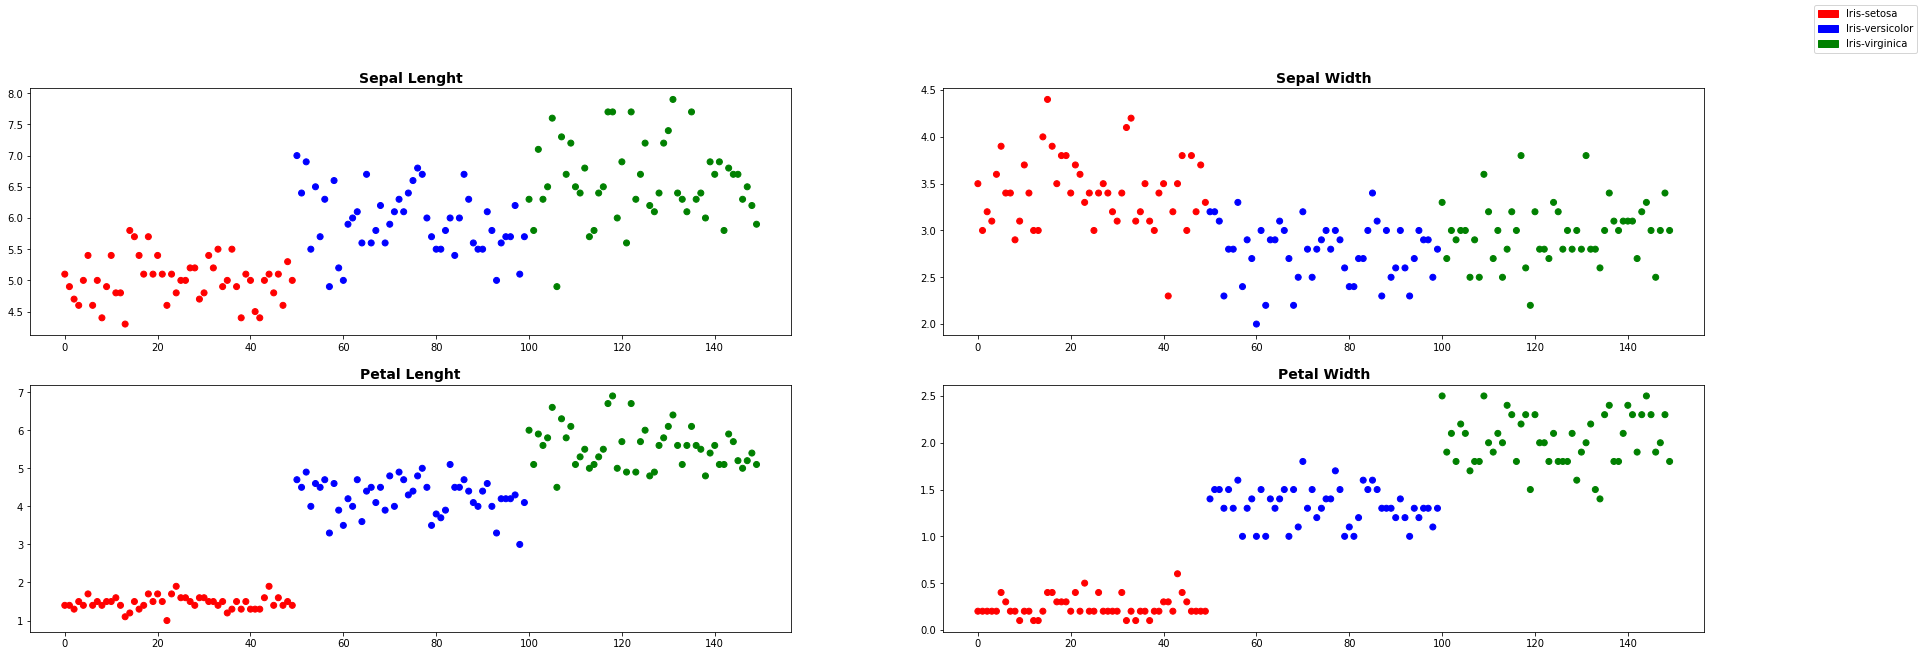

In [5]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(30, 10)
colors = {'Iris-setosa':'red', 'Iris-virginica':'green', 'Iris-versicolor':'blue'}

axs[0, 0].scatter(list(range(150)), iris_data['sepal_lenght'], c=iris_data['class_labels'].map(colors))
axs[0, 0].set_title('Sepal Lenght', fontsize=14, fontweight='bold')

axs[0, 1].scatter(list(range(150)), iris_data['sepal_width'], c=iris_data['class_labels'].map(colors))
axs[0, 1].set_title('Sepal Width', fontsize=14, fontweight='bold')

axs[1, 0].scatter(list(range(150)), iris_data['petal_lenght'], c=iris_data['class_labels'].map(colors))
axs[1, 0].set_title('Petal Lenght', fontsize=14, fontweight='bold')

axs[1, 1].scatter(list(range(150)), iris_data['petal_width'], c=iris_data['class_labels'].map(colors))
axs[1, 1].set_title('Petal Width', fontsize=14, fontweight='bold')

red_patch = mpatches.Patch(color='red', label='Iris-setosa')
blue_patch = mpatches.Patch(color='blue', label='Iris-versicolor')
green_patch = mpatches.Patch(color='green', label='Iris-virginica')

fig.legend(handles=[red_patch, blue_patch, green_patch])
plt.show()

# Training First Tree Classifier
Foi efetuado o treinamento da árvore de decisão, foi utilizado o dataset original, os resultados obtidos com esse modelos devem ser comparados com outros modelos no decorrer do projeto.

In [6]:
first_classifier=tree.DecisionTreeClassifier()
first_classifier.fit(x_train, y_train)
first_model_predictions=first_classifier.predict(x_test)

# Plotting First Trained Tree
Para melhor compreensão e para fins tando de comparação quanto debug, foi plotada a árvore obtida com o treinamento sobre o dataset original.

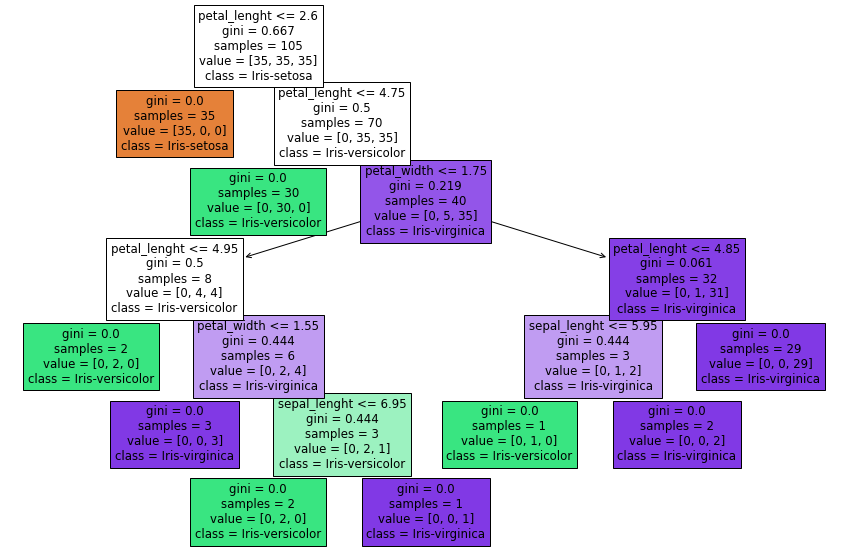

In [7]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(first_classifier, feature_names=list(x.columns.values), class_names=first_classifier.classes_, filled=True)

# Generating First Confusion Matrix
Através da matriz de confusão gerada a partir das predições do primeiro modelo, pode-se aferir que o primeiro modelo é preciso, apresentando apenas um erro dentre as 45 predições efetuadas.

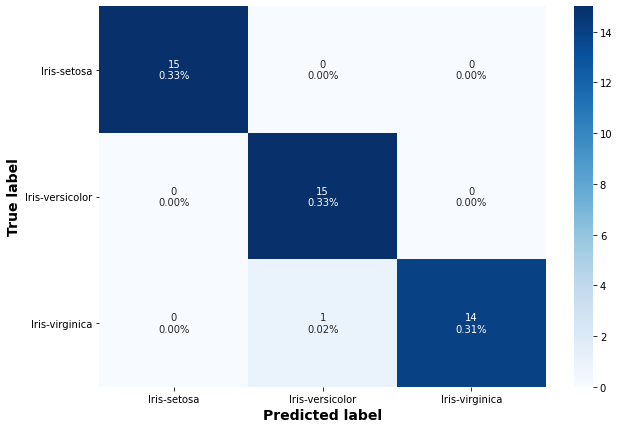

In [8]:
first_model_confusion_matrix = confusion_matrix(y_test, first_model_predictions)

first_model_confusion_matrix_counts = first_model_confusion_matrix.flatten()
group_percentages = [f'{value:.2f}%' for value in first_model_confusion_matrix.flatten()/np.sum(first_model_confusion_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(first_model_confusion_matrix_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize=(10,7))
heatmap(first_model_confusion_matrix, annot=labels, fmt='', xticklabels=first_classifier.classes_, yticklabels=first_classifier.classes_, cmap='Blues')
plt.ylabel('True label', fontsize=14, fontweight='bold')
plt.yticks(rotation=0)
plt.xlabel('Predicted label', fontsize=14, fontweight='bold')
plt.show()

# Applying Data Preprocessing
Para o segundo modelo, também baseado em árvore de decisão, foi efetuado o pré processamento dos dados para fins de comparação com o primeiro modelo e com os próximos a serem utilizados, dessa forma pode-se tentar obter modelos mais precisos e analisar como os dados obtidos após a aplicação dos próximos métodos podem afetar o modelo obtido.
Foram aplicados:

*   Busca por missing values.
*   Conversão de dados categóricos para numéricos.
*   Padronização dos dados.

In [10]:
process_dataset = iris_data
process_dataset.shape

(150, 5)

# Check for Missing Values

In [11]:
process_dataset.isnull().sum()

sepal_lenght    0
sepal_width     0
petal_lenght    0
petal_width     0
class_labels    0
dtype: int64

# Converting Target Feature to Numerical Values

In [12]:
process_dataset.dtypes

sepal_lenght    float64
sepal_width     float64
petal_lenght    float64
petal_width     float64
class_labels     object
dtype: object

In [13]:
label_encoder = LabelEncoder()
class_labels_processed = label_encoder.fit_transform(process_dataset['class_labels'])
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

In [14]:
process_dataset['class_labels'] = class_labels_processed

# Splitting Dataset

In [15]:
processed_x = process_dataset[['sepal_lenght','sepal_width','petal_lenght','petal_width']]
processed_y = process_dataset[['class_labels']]
processed_x_train, processed_x_test, processed_y_train, processed_y_test=train_test_split(processed_x,processed_y,test_size=.30, stratify=processed_y, random_state=random_seed)

# Standardize

In [16]:
scaler = StandardScaler()
processed_x_train = pd.DataFrame(scaler.fit_transform(processed_x_train), columns=processed_x_train.columns)
processed_x_test = pd.DataFrame(scaler.transform(processed_x_test), columns=processed_x_test.columns)
processed_x_train

,sepal_lenght,sepal_width,petal_lenght,petal_width
0,-0.430106,2.631185,-1.332697,-1.303804
1,-0.550536,0.769184,-1.165380,-1.303804
2,0.653762,0.303684,0.842430,1.444654
3,1.015051,0.536434,1.065520,1.182896
4,-1.032255,0.303684,-1.444242,-1.303804
...,...,...,...,...
100,-1.634404,-1.791068,-1.388470,-1.172925
101,-0.068817,-1.092817,0.117388,0.004986
102,-1.032255,0.769184,-1.221152,-1.042046
103,-1.513975,0.070933,-1.276925,-1.303804


# Baseline Prediction

In [17]:
process_dataset.class_labels.value_counts(normalize= True)

2    0.333333
1    0.333333
0    0.333333
Name: class_labels, dtype: float64

# Retrain After Preprocessing
Foi efetuado o treinamento da segunda árvore de decisão, foi utilizado o dataset após o tratamento de dados, os resultados obtidos com esse modelos devem ser comparados com outros modelos no decorrer do projeto.

In [18]:
second_classifier=tree.DecisionTreeClassifier()
second_classifier.fit(processed_x_train, processed_y_train)
second_model_predictions=second_classifier.predict(processed_x_test)

# Plotting Second Trained Tree (After Data Processing)
Para melhor compreensão e para fins tando de comparação quanto debug, foi plotada a árvore obtida com o treinamento sobre o dataset pós tratamento.

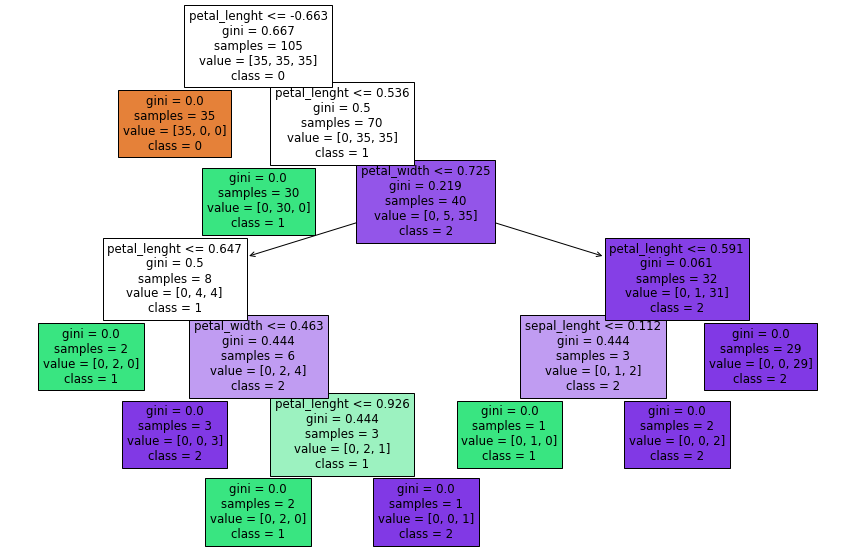

In [19]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(second_classifier, feature_names=list(processed_x.columns.values), class_names=list(map(str, second_classifier.classes_)), filled=True)

# Generating Second Confusion Matrix
Através da matriz de confusão gerada a partir das predições do segundo modelo, pode-se aferir que o segundo modelo é preciso, apresentando apenas um erro dentre as 45 predições efetuadas.

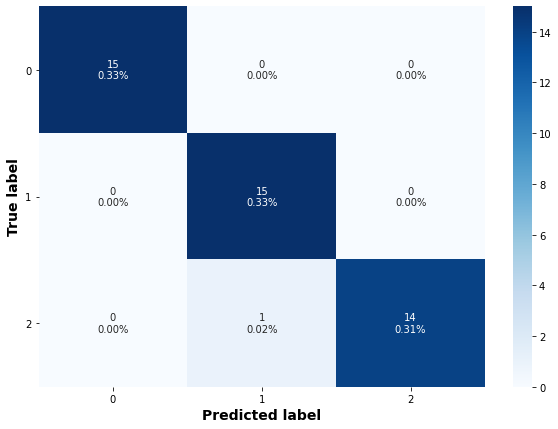

In [20]:
second_model_confusion_matrix = confusion_matrix(processed_y_test, second_model_predictions)

second_model_confusion_matrix_counts = second_model_confusion_matrix.flatten()
group_percentages = [f'{value:.2f}%' for value in second_model_confusion_matrix.flatten()/np.sum(second_model_confusion_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(second_model_confusion_matrix_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize=(10,7))
heatmap(second_model_confusion_matrix, annot=labels, fmt='', xticklabels=second_classifier.classes_, yticklabels=second_classifier.classes_, cmap='Blues')
plt.ylabel('True label', fontsize=14, fontweight='bold')
plt.yticks(rotation=0)
plt.xlabel('Predicted label', fontsize=14, fontweight='bold')
plt.show()

# Plotting Training Dataset para correlação
O próximo passo é avalair a correlação dos dados e explorar os 'clusters' presentes em petal_length e petal_width, conforme citado anteriormente.

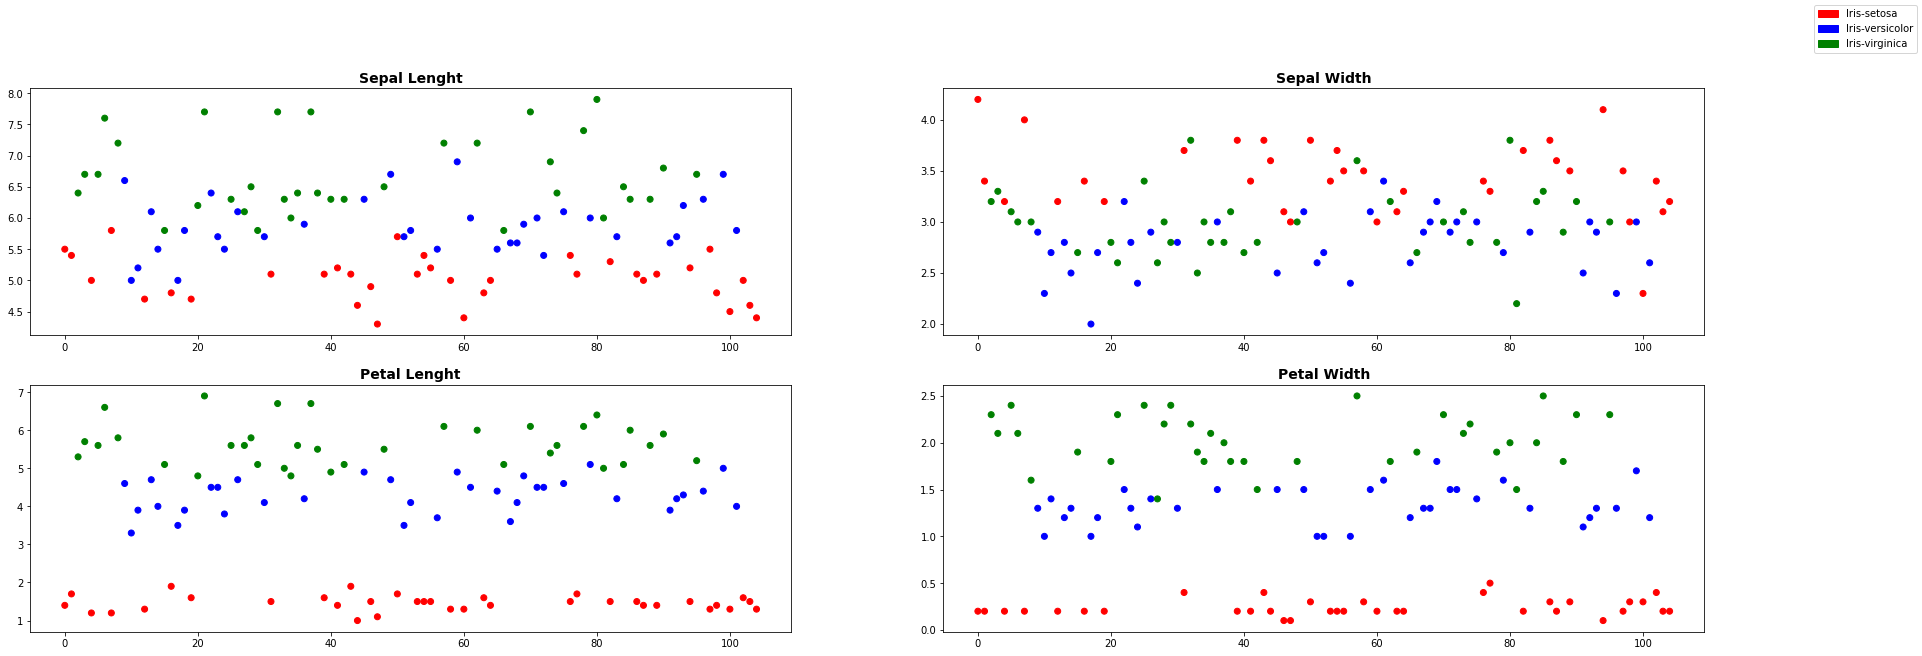

In [22]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(30, 10)
colors = {'Iris-setosa':'red', 'Iris-virginica':'green', 'Iris-versicolor':'blue'}

axs[0, 0].scatter(list(range(105)), x_train['sepal_lenght'], c=y_train['class_labels'].map(colors))
axs[0, 0].set_title('Sepal Lenght', fontsize=14, fontweight='bold')

axs[0, 1].scatter(list(range(105)), x_train['sepal_width'], c=y_train['class_labels'].map(colors))
axs[0, 1].set_title('Sepal Width', fontsize=14, fontweight='bold')

axs[1, 0].scatter(list(range(105)), x_train['petal_lenght'], c=y_train['class_labels'].map(colors))
axs[1, 0].set_title('Petal Lenght', fontsize=14, fontweight='bold')

axs[1, 1].scatter(list(range(105)), x_train['petal_width'], c=y_train['class_labels'].map(colors))
axs[1, 1].set_title('Petal Width', fontsize=14, fontweight='bold')

red_patch = mpatches.Patch(color='red', label='Iris-setosa')
blue_patch = mpatches.Patch(color='blue', label='Iris-versicolor')
green_patch = mpatches.Patch(color='green', label='Iris-virginica')

fig.legend(handles=[red_patch, blue_patch, green_patch])
plt.show()

# Correlação
Foi medida a correlação entre os dados do Dataset

In [23]:
process_dataset.corr(method ='pearson') 

,sepal_lenght,sepal_width,petal_lenght,petal_width,class_labels
sepal_lenght,1.000000,-0.109369,0.871754,0.817954,0.782561
sepal_width,-0.109369,1.000000,-0.420516,-0.356544,-0.419446
petal_lenght,0.871754,-0.420516,1.000000,0.962757,0.949043
petal_width,0.817954,-0.356544,0.962757,1.000000,0.956464
class_labels,0.782561,-0.419446,0.949043,0.956464,1.000000


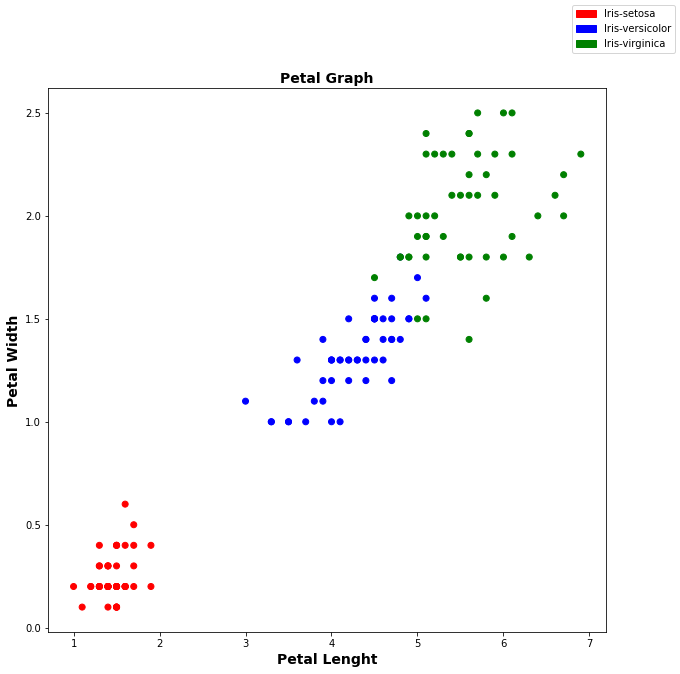

In [24]:
fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
#{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
#colors = {'Iris-setosa':'red', 'Iris-virginica':'green', 'Iris-versicolor':'blue'}
colors = {0:'red', 2:'green', 1:'blue'}

axs.scatter(process_dataset['petal_lenght'], process_dataset['petal_width'], c=process_dataset['class_labels'].map(colors))
axs.set_title('Petal Graph', fontsize=14, fontweight='bold')

red_patch = mpatches.Patch(color='red', label='Iris-setosa')
blue_patch = mpatches.Patch(color='blue', label='Iris-versicolor')
green_patch = mpatches.Patch(color='green', label='Iris-virginica')

plt.xlabel('Petal Lenght', fontsize=14, fontweight='bold')
plt.ylabel('Petal Width', fontsize=14, fontweight='bold')
fig.legend(handles=[red_patch, blue_patch, green_patch])
plt.show()

# Splitting Dataset
Nos gráficos anteriores foi possível perceber a correlação entre os petal_width e petal_lenght, dessa forma pode-se considerar que tais dados são mais significativos para a generalização do modelo. Dessa forma essas duas features foram utilizadas para gerar um novo dataset ao qual deve utilizado para treinar um novo modelo.

In [25]:
corr_x = process_dataset[['petal_lenght','petal_width']]
corr_y = process_dataset[['class_labels']]
corr_x_train, corr_x_test, corr_y_train, corr_y_test=train_test_split(corr_x,corr_y,test_size=.30, stratify=corr_y, random_state=random_seed)

In [26]:
corr_classifier=tree.DecisionTreeClassifier()
corr_classifier.fit(corr_x_train, corr_y_train)
corr_model_predictions=corr_classifier.predict(corr_x_test)

# Plotting Third Trained Tree
Para melhor compreensão e para fins tando de comparação quanto debug, foi plotada a árvore obtida com o treinamento sobre o dataset gerado sobre a correlação obtida.

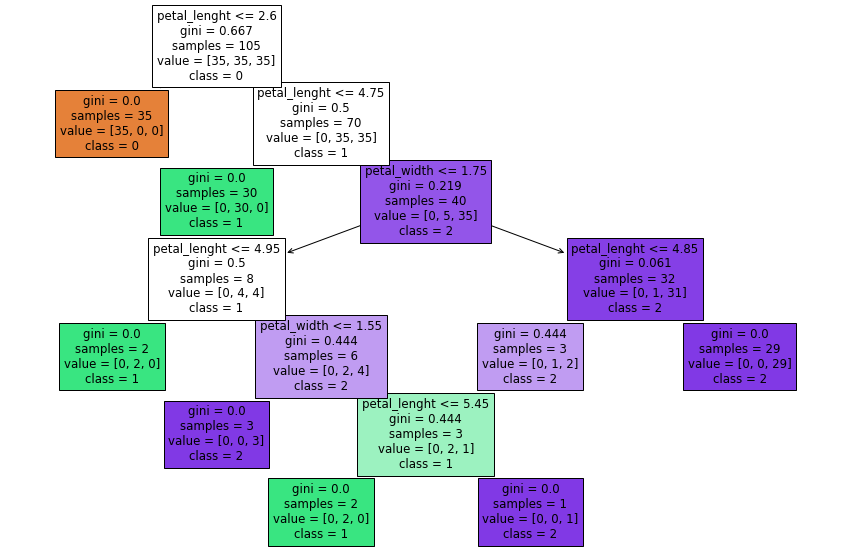

In [27]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(corr_classifier, feature_names=list(corr_x.columns.values), class_names=list(map(str, corr_classifier.classes_)), filled=True)

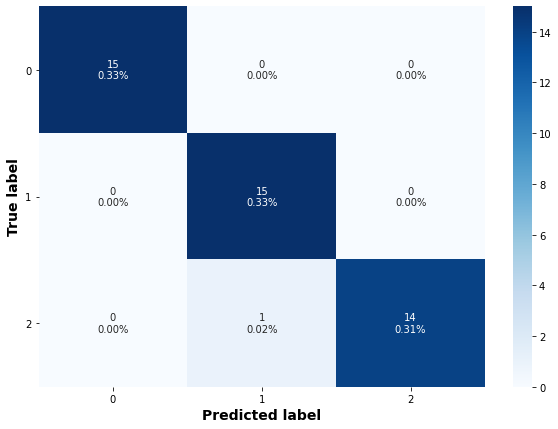

In [28]:
corr_model_confusion_matrix = confusion_matrix(corr_y_test, corr_model_predictions)

corr_model_confusion_matrix_counts = corr_model_confusion_matrix.flatten()
group_percentages = [f'{value:.2f}%' for value in corr_model_confusion_matrix.flatten()/np.sum(corr_model_confusion_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(corr_model_confusion_matrix_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize=(10,7))
heatmap(corr_model_confusion_matrix, annot=labels, fmt='', xticklabels=corr_classifier.classes_, yticklabels=corr_classifier.classes_, cmap='Blues')
plt.ylabel('True label', fontsize=14, fontweight='bold')
plt.yticks(rotation=0)
plt.xlabel('Predicted label', fontsize=14, fontweight='bold')
plt.show()

#Treino SVM
Foi gerado também um modelo de SVM, tendo em vista que os dados estavam bem separados, é válido analisar a divisão em áreas.

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


Text(0.5, 1.0, 'SVM Decision Region Boundary')

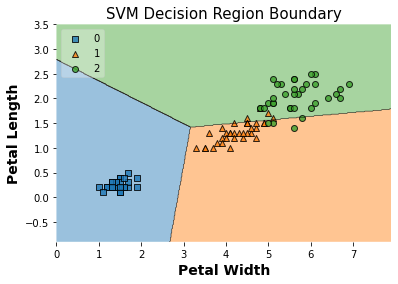

In [30]:
svc_classifier=LinearSVC(max_iter=3250)
svc_y_train = np.ravel(corr_y_train)
svc_y_test = np.ravel(corr_y_test)
svc_classifier.fit(corr_x_train, svc_y_train)

plot_decision_regions(X=corr_x_train.values, 
                      y=svc_y_train,
                      clf=svc_classifier,
                      legend=2)
plt.xlabel('Petal Width', fontsize=14, fontweight='bold')
plt.ylabel('Petal Length', fontsize=14, fontweight='bold')
plt.title('SVM Decision Region Boundary', size=15)

In [31]:
svc_model_predictions=svc_classifier.predict(corr_x_test)

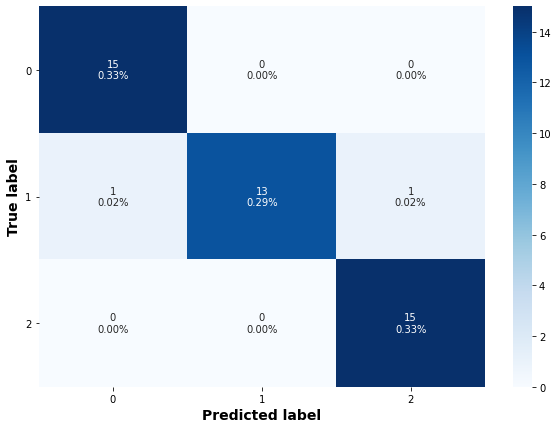

In [32]:
svc_model_confusion_matrix = confusion_matrix(corr_y_test, svc_model_predictions)

svc_model_confusion_matrix_counts = svc_model_confusion_matrix.flatten()
group_percentages = [f'{value:.2f}%' for value in svc_model_confusion_matrix.flatten()/np.sum(svc_model_confusion_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(svc_model_confusion_matrix_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize=(10,7))
heatmap(svc_model_confusion_matrix, annot=labels, fmt='', xticklabels=svc_classifier.classes_, yticklabels=svc_classifier.classes_, cmap='Blues')
plt.ylabel('True label', fontsize=14, fontweight='bold')
plt.yticks(rotation=0)
plt.xlabel('Predicted label', fontsize=14, fontweight='bold')
plt.show()

In [33]:
print('First Model Metrics \n')
print(classification_report(y_test, first_model_predictions))
print('\nSecond Model Metrics \n')
print(classification_report(processed_y_test, second_model_predictions))
print('\nCorr Model Metrics \n')
print(classification_report(corr_y_test, corr_model_predictions))
print('\nSVC Model Metrics \n')
print(classification_report(svc_y_test, svc_model_predictions))

First Model Metrics 

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.94      1.00      0.97        15
 Iris-virginica       1.00      0.93      0.97        15

       accuracy                           0.98        45
      macro avg       0.98      0.98      0.98        45
   weighted avg       0.98      0.98      0.98        45


Second Model Metrics 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.93      0.97        15

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45


Corr Model Metrics 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0